# Producing the main figure for the paper

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [88]:
gaia_mc0 = pd.read_csv("gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
m &= gaia_mc1.b.values < bmax
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

gaia_mc = gaia_mc1.iloc[m]

(31357, 133)
(11700, 133) no visual binaries or subgiants
(11436, 133) no large vb uncertainties
(11272, 133) no faint stars
(10586, 133) no rapid rotators
(10454, 133) no hot or cold stars
(6879, 133) no high latitude stars


Make cuts in log age.

In [89]:
# age_bins = 10**np.linspace(np.log10(.5), np.log10(4.5), 5)
age_bins = 10**np.linspace(np.log10(.5), np.log10(4.5), 7)
# age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Set up color values.

In [90]:
cmap = plt.cm.get_cmap('viridis_r')
vmin, vmax = np.log10(1e9*min(mid_age_bins)), np.log10(1e9*max(mid_age_bins))
log_agebins = np.log10(age_bins*1e9)
age_midbin = np.diff(log_agebins)*.5 + log_agebins[:-1]
color_values = (age_midbin - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format data.

In [91]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
# v = gaia_mc.v_ra.values
# v = gaia_mc.v_dec.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 10)
# tbins = np.linspace(min(x), max(x), 7)
# tbins = np.linspace(min(x), max(x), 6)
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

In [92]:
def betterstep_scatter(bins, y, c, label, **kwargs):
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(new_x, new_y, color=c, lw=2, rasterized=True, label=label)

Make main figure

  0%|          | 0/1000 [00:00<?, ?it/s]

niter =  3 7 stars removed kurtosis =  0.18548393498883176
niter =  5 6 stars removed kurtosis =  -0.21368388514315484
niter =  2 3 stars removed kurtosis =  -0.373393603258354
niter =  4 17 stars removed kurtosis =  0.023108771822246243
niter =  4 20 stars removed kurtosis =  0.18962530532856992
niter =  3 8 stars removed kurtosis =  -0.06711932126244324
niter =  3 7 stars removed kurtosis =  0.18548393498883176


  7%|▋         | 69/1000 [00:00<00:01, 683.30it/s]

niter =  5 6 stars removed kurtosis =  -0.21368388514315484


  7%|▋         | 72/1000 [00:00<00:01, 719.65it/s]

niter =  2 3 stars removed kurtosis =  -0.373393603258354


  6%|▋         | 63/1000 [00:00<00:01, 628.97it/s]

niter =  4 17 stars removed kurtosis =  0.023108771822246243


  6%|▋         | 65/1000 [00:00<00:01, 644.15it/s]

niter =  4 20 stars removed kurtosis =  0.18962530532856992


  8%|▊         | 76/1000 [00:00<00:01, 757.03it/s]

niter =  3 8 stars removed kurtosis =  -0.06711932126244324


100%|██████████| 1000/1000 [00:01<00:00, 714.82it/s]


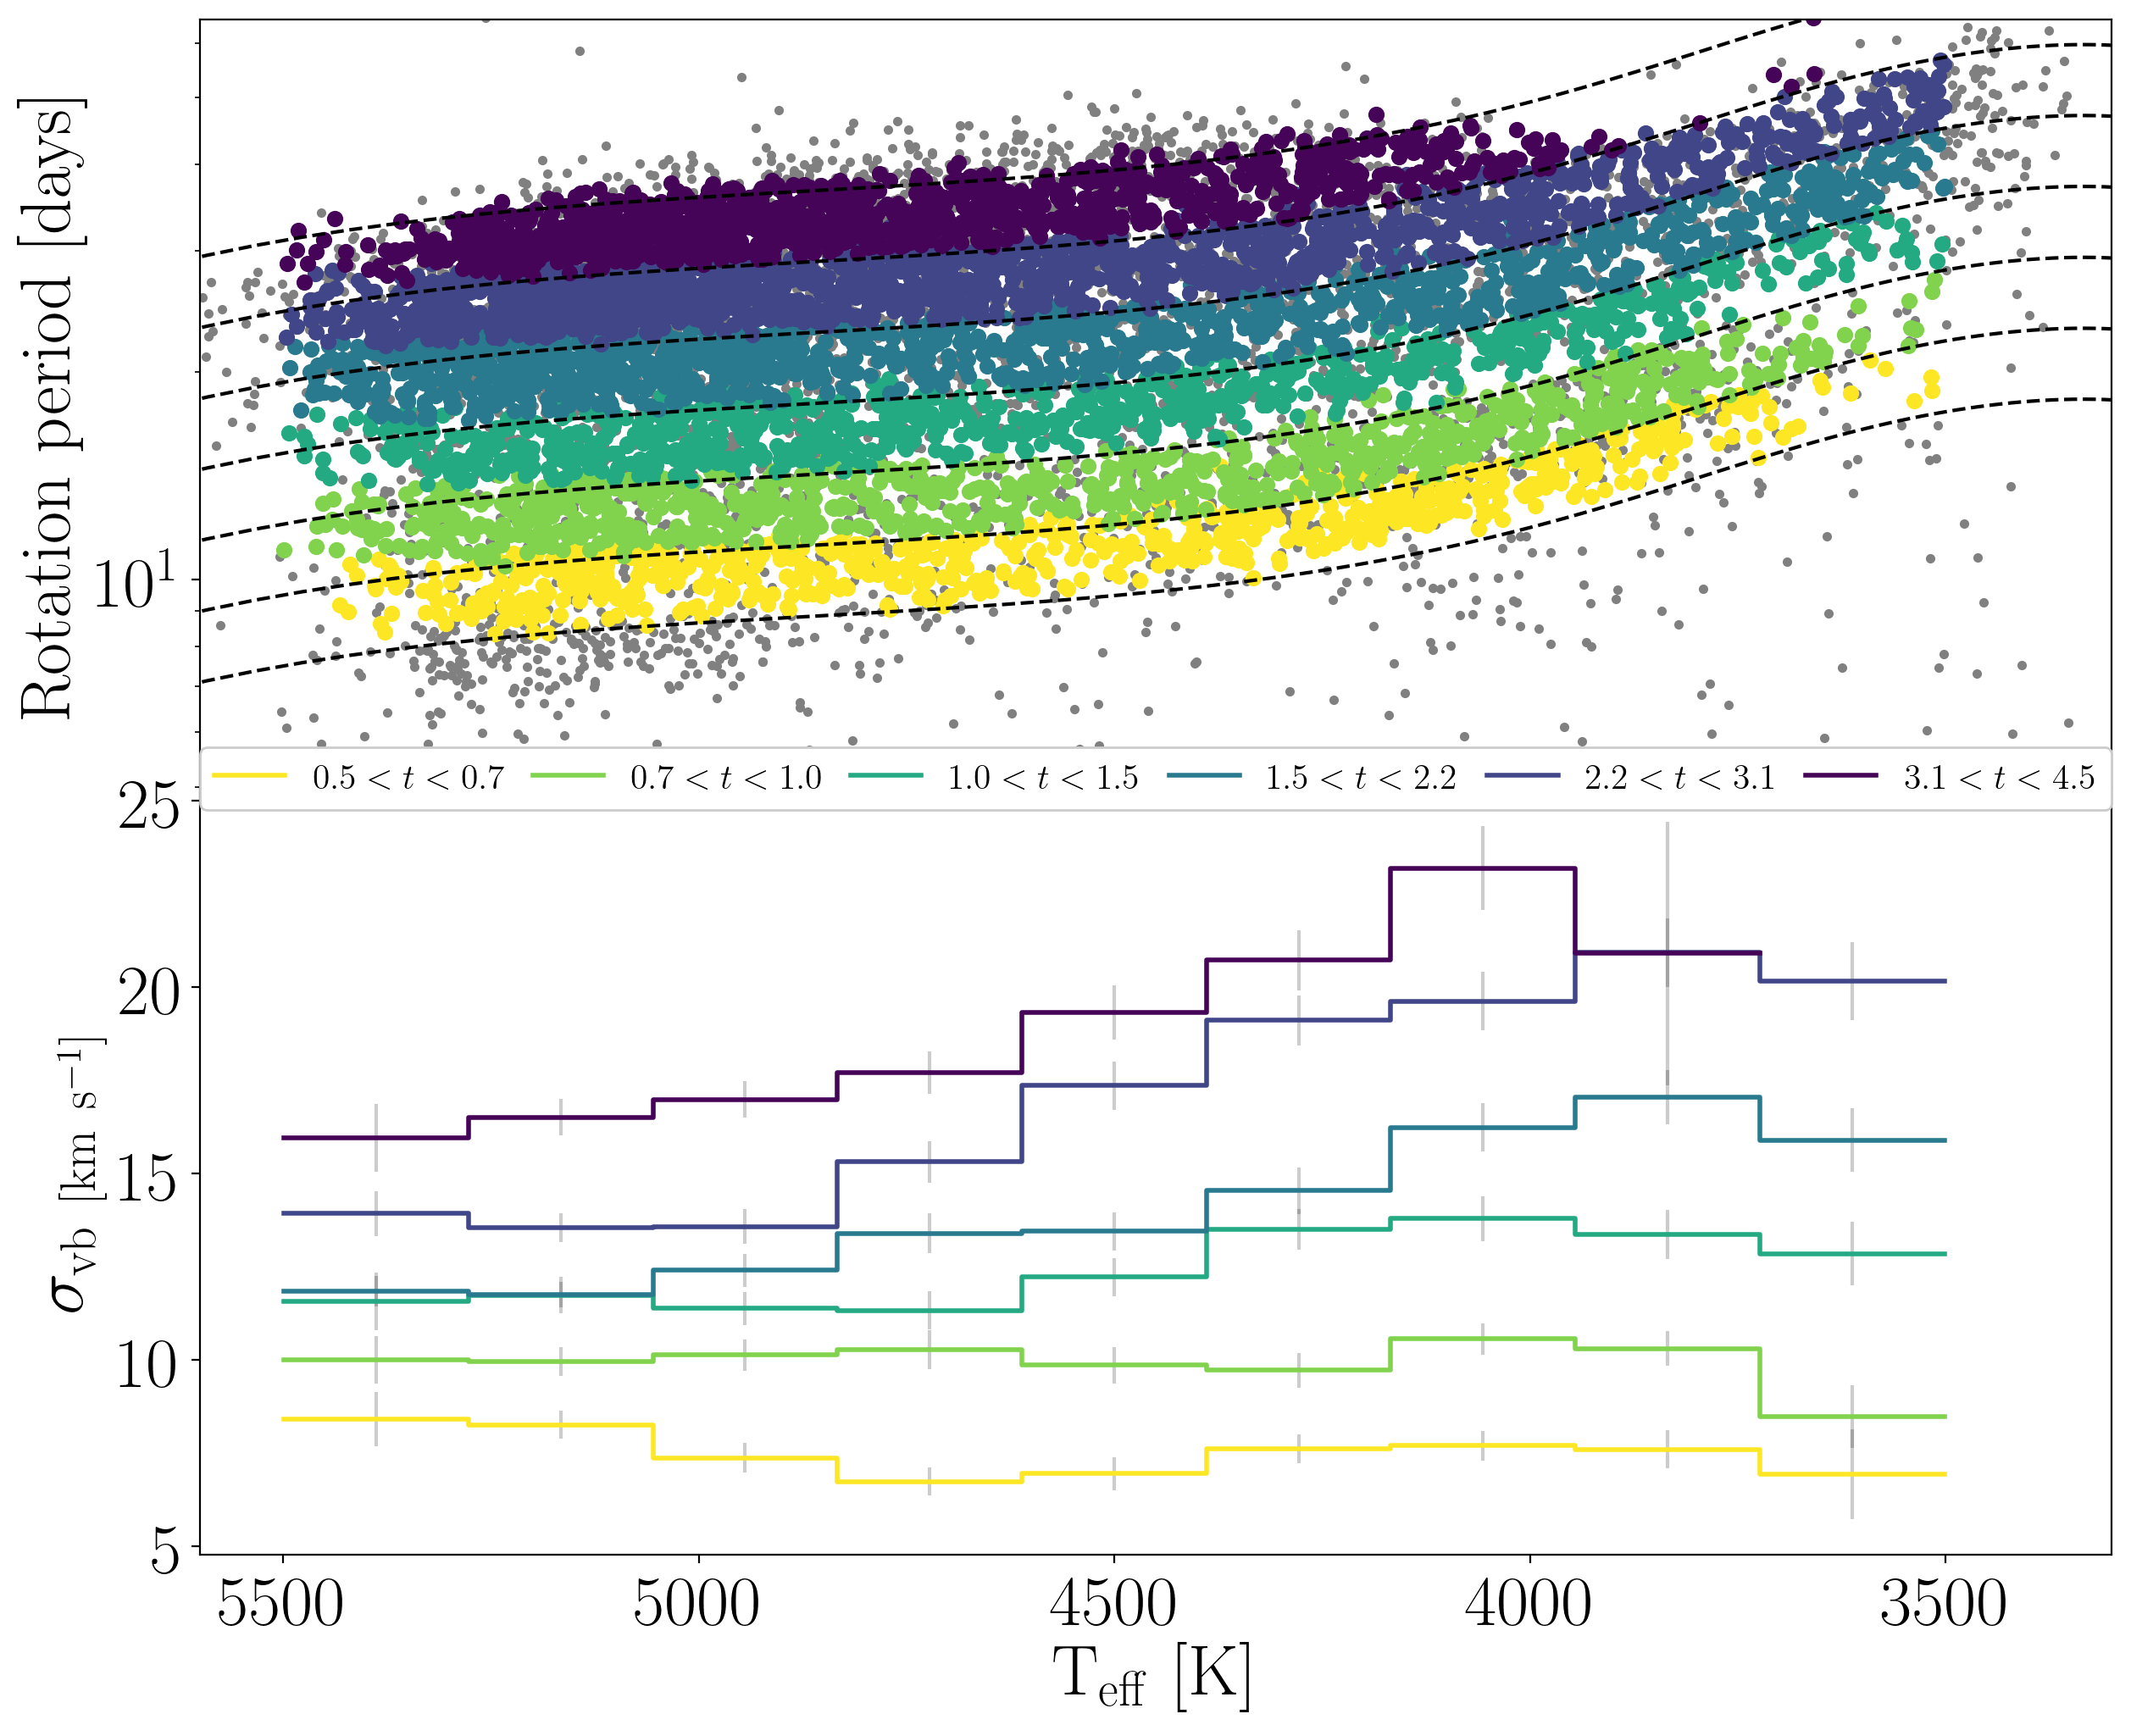

In [93]:
from stardate.lhf import gk_rotation_model
from photometric_teff import bprp_to_teff

fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter.
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Plot lines
xs_bprp = np.linspace(.8, 2.8, 100)
xs_teff = bprp_to_teff(xs_bprp)
log10_ages = np.log10(age_bins*1e9)

# Top panel: period-teff relations
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
                      vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=35,
                      label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    
    prots = 10**gk_rotation_model(log10_ages[i], xs_bprp)
    plt.plot(xs_teff, prots, "k--")
prots = 10**gk_rotation_model(log10_ages[-1], xs_bprp)
plt.plot(xs_teff, prots, "k--")

    
# Add the sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(5, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
                                     verr[m][clipping_mask],
                                     tbins, 1000, method="std")
    ds[i, :] = d
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr
    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.2,
                 rasterized=True)
    
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb~[km~s^{-1}]}$")
ax2.set_xlim(xlim)
plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)

plt.subplots_adjust(hspace=0, right=0.83)
plt.savefig("paper/age_cut.pdf")

Now make cuts in rotation period.

In [76]:
period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
# period_bins = 10**np.linspace(np.log10(7), np.log10(50), 5)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

pds, pderrs = [np.zeros((len(period_bins), len(tbins[:-1]))) for i in range(2)]

Set the color scale.

In [77]:
cmap = plt.cm.get_cmap('viridis_r')
vmin, vmax = min(mid_period_bins), max(mid_period_bins)
color_values = (mid_period_bins - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format the data.

In [78]:
y = gaia_mc.Prot.values

  0%|          | 0/1000 [00:00<?, ?it/s]

niter =  1 0 stars removed kurtosis =  -0.6673965703633091
niter =  2 3 stars removed kurtosis =  0.3683980588301705
niter =  3 6 stars removed kurtosis =  -0.189563868094051
niter =  3 7 stars removed kurtosis =  -0.35062755830797476
niter =  4 14 stars removed kurtosis =  -0.2812973715848166
niter =  4 12 stars removed kurtosis =  0.04827348435893741
niter =  2 3 stars removed kurtosis =  -0.041443496792684
niter =  3 4 stars removed kurtosis =  -0.03196976781400451
niter =  1 0 stars removed kurtosis =  -0.6673965703633091


  8%|▊         | 85/1000 [00:00<00:01, 843.02it/s]

niter =  2 3 stars removed kurtosis =  0.3683980588301705


  7%|▋         | 73/1000 [00:00<00:01, 727.39it/s]

niter =  3 6 stars removed kurtosis =  -0.189563868094051


  7%|▋         | 66/1000 [00:00<00:01, 657.80it/s]

niter =  3 7 stars removed kurtosis =  -0.35062755830797476


  7%|▋         | 72/1000 [00:00<00:01, 717.02it/s]

niter =  4 14 stars removed kurtosis =  -0.2812973715848166


  7%|▋         | 68/1000 [00:00<00:01, 675.23it/s]

niter =  4 12 stars removed kurtosis =  0.04827348435893741


  7%|▋         | 72/1000 [00:00<00:01, 716.39it/s]

niter =  2 3 stars removed kurtosis =  -0.041443496792684


  9%|▉         | 89/1000 [00:00<00:01, 888.58it/s]

niter =  3 4 stars removed kurtosis =  -0.03196976781400451


100%|██████████| 1000/1000 [00:01<00:00, 815.96it/s]


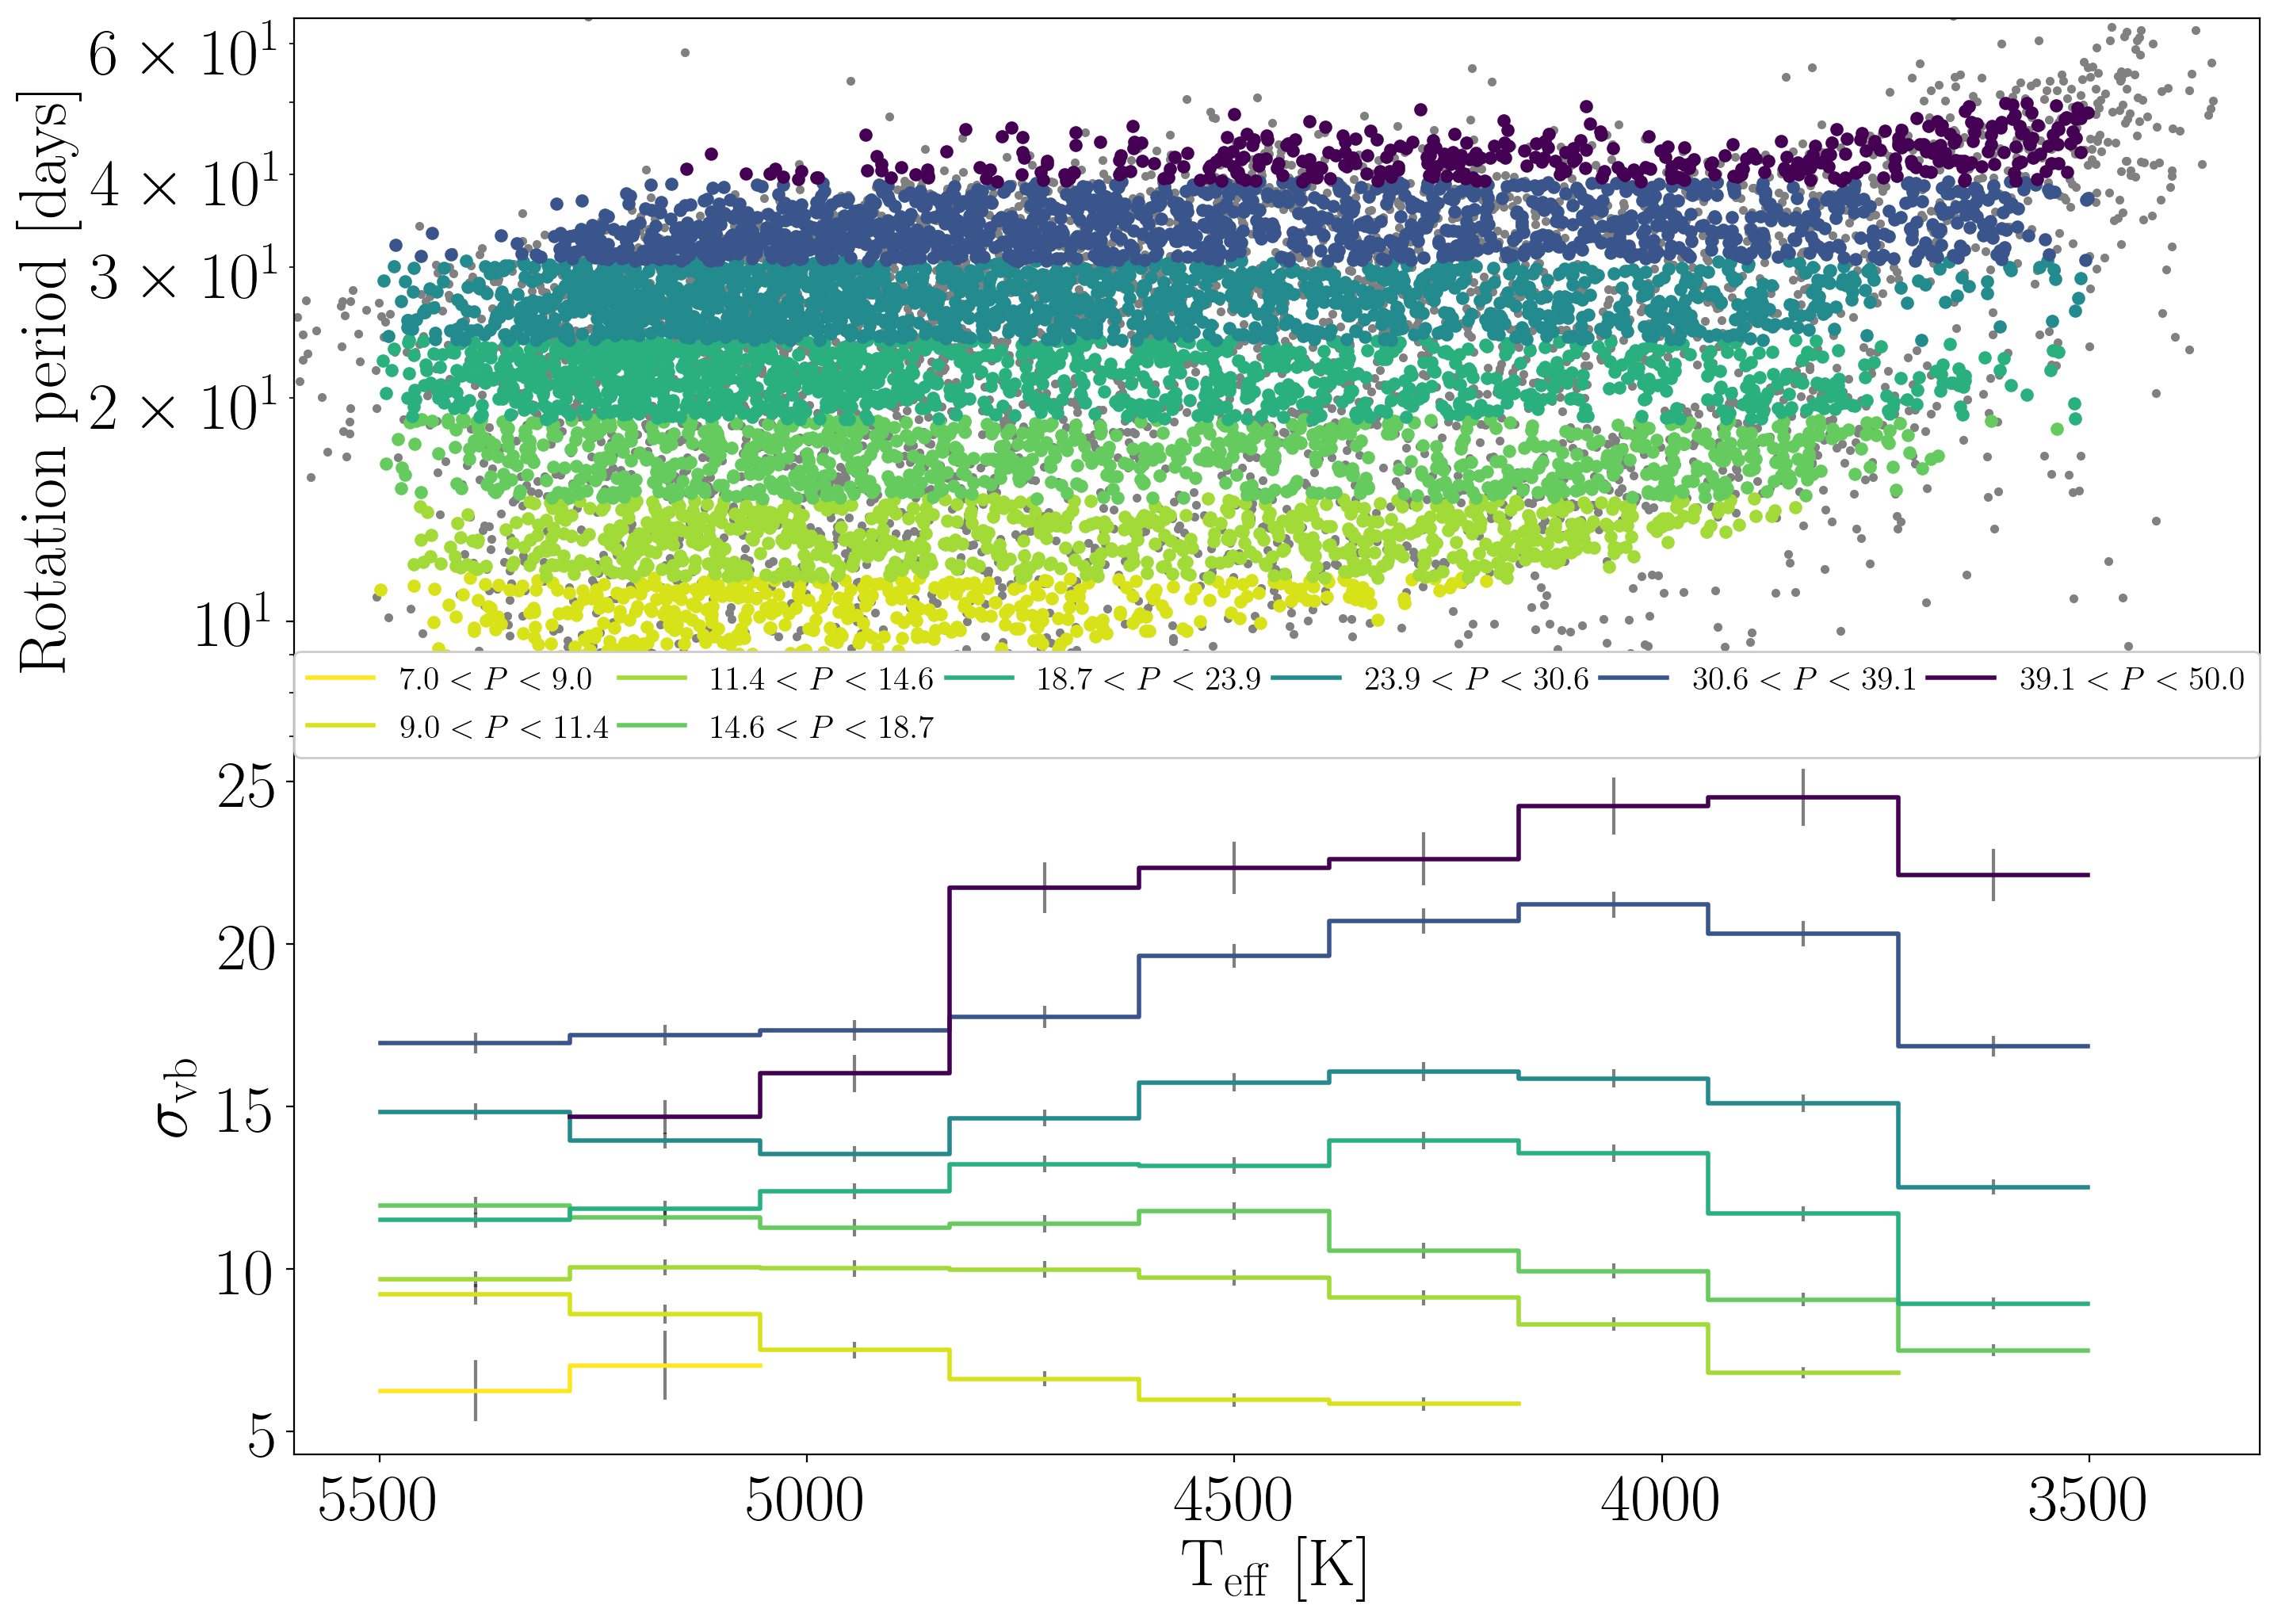

In [79]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Colored sections in period-color space
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
                      vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=25,
                      label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    
# Sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(7, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

# Velocity-teff plot
ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped,
                                     xerr[m][clipping_mask], verr[m][clipping_mask],
                            tbins, 1000, method="std")
    derr = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))

    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.5,
                 rasterized=True)

plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb}$")
ax2.set_xlim(xlim)
plt.subplots_adjust(hspace=0)  # , right=0.83)
plt.savefig("paper/period_cut.pdf")

In [80]:
# vmin, vmax = np.min(ds[ds > 0]), np.max(ds[np.isfinite(ds)])
# color_values = (ds - vmin)/(vmax - vmin)
# rgba = cmap(color_values)

In [81]:
cmap = plt.cm.get_cmap('plasma_r')
pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Calculate a 1.1 Gyr gyrochrone.

In [82]:
from stardate.lhf import gk_rotation_model
from photometric_teff import bprp_to_teff

xs_bprp = np.linspace(.8, 2.8, 100)
log10_age = np.log10(1.1*1e9)
log10_age_praesepe = np.log10(.65*1e9)
prots = 10**gk_rotation_model(log10_age, xs_bprp)
prots_praesepe = 10**gk_rotation_model(log10_age_praesepe, xs_bprp)
xs_teff = bprp_to_teff(xs_bprp)

niter =  1 0 stars removed kurtosis =  -0.6673965703633091
niter =  2 3 stars removed kurtosis =  0.3683980588301705
niter =  3 6 stars removed kurtosis =  -0.189563868094051
niter =  3 7 stars removed kurtosis =  -0.35062755830797476
niter =  4 14 stars removed kurtosis =  -0.2812973715848166
niter =  4 12 stars removed kurtosis =  0.04827348435893741
niter =  2 3 stars removed kurtosis =  -0.041443496792684
niter =  3 4 stars removed kurtosis =  -0.03196976781400451
niter =  1 0 stars removed kurtosis =  -0.6673965703633091
niter =  2 3 stars removed kurtosis =  0.3683980588301705
niter =  3 6 stars removed kurtosis =  -0.189563868094051
niter =  3 7 stars removed kurtosis =  -0.35062755830797476
niter =  4 14 stars removed kurtosis =  -0.2812973715848166
niter =  4 12 stars removed kurtosis =  0.04827348435893741
niter =  2 3 stars removed kurtosis =  -0.041443496792684
niter =  3 4 stars removed kurtosis =  -0.03196976781400451


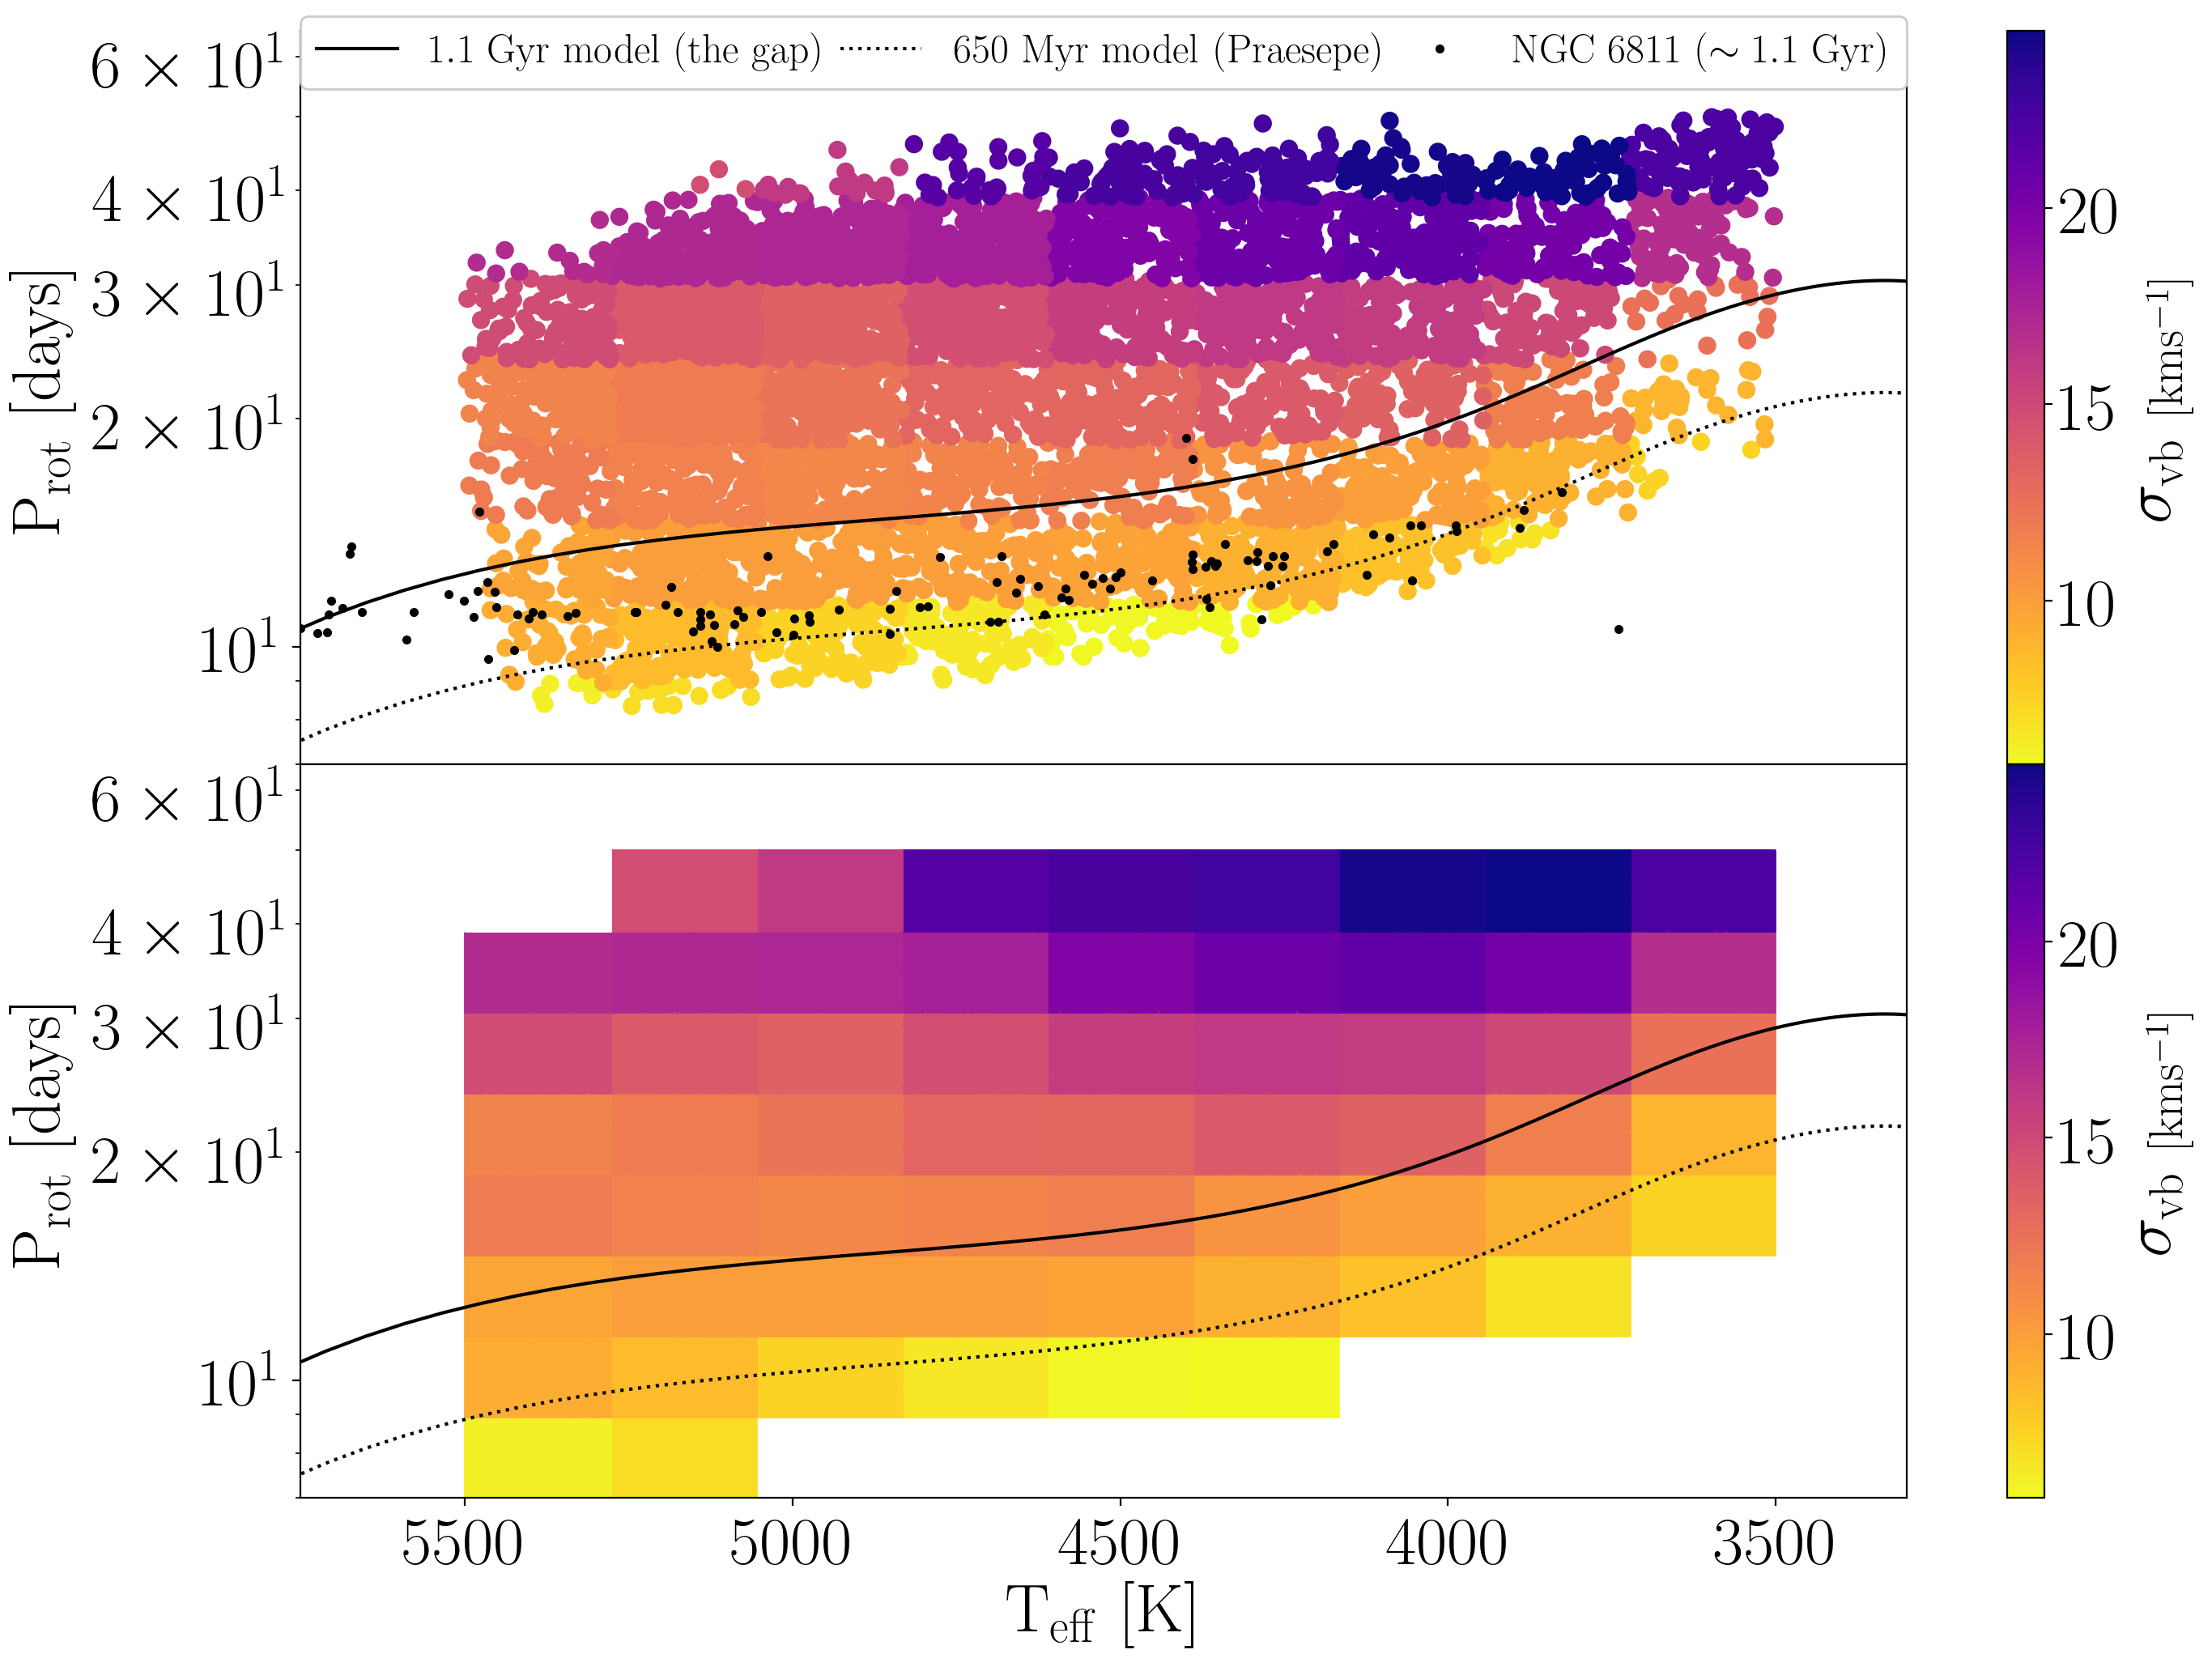

In [83]:
plt.rcParams.update({'legend.fontsize': 18})

fig = plt.figure(figsize=(16, 12), dpi=200)
ax3 = fig.add_subplot(211)

# ax3.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0, label=None)

# for i, m in enumerate(age_masks):
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
#                           c=np.ones_like(y[m][clipping_mask][tm])*ds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=1, s=50, cmap="plasma_r")

# 1.1 Gyr Gyrochrone        
plt.plot(xs_teff, prots, color="k", zorder=10, label="$\mathrm{1.1~Gyr~model~(the~gap)}$")
plt.plot(xs_teff, prots_praesepe, color="k", ls=":", zorder=10, label="$\mathrm{650~Myr~model~(Praesepe)}$")

# NGC 6811
df = pd.read_csv("NGC6811.csv")
plt.plot(df.teff, df.prot, "k.", zorder=9, label="$\mathrm{NGC~6811~(\sim1.1~Gyr)}$")

# ax3.legend()
plt.legend(bbox_to_anchor=(0., .92, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
# ax1.xlabel("$\mathrm{T_{eff}~[K]}$")
ax3.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax3.set_xlim(5750, xlim[1])
ax3.set_yscale("log")
ax3.set_ylim(7, 65)
plt.setp(ax3.get_xticklabels(), visible=False)

ax4 = fig.add_subplot(212, sharex=ax3)
# plt.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".1", alpha=.1, ms=2,
#          mec="none", rasterized=True, zorder=1)
# plt.plot(gaia_mc.color_teffs, gaia_mc.Prot, "ko", mec="k", ms=.5, 
#          alpha=.2, rasterized=True, zorder=3)

for i, m in enumerate(period_masks):
#     ax4.axhline(period_bins[i], color="k", ls="--")
    
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, # edgecolor="k",
                          rasterized=True, zorder=2, s=.01, cmap="plasma_r")
        
        xs = np.linspace(tbins[j], tbins[j+1], 10)
        color = prgba_plasma[i, j]
        if not np.isfinite(pds[i, j]):
            color = "w"
        ax4.fill_between(xs, np.ones_like(xs)*period_bins[i], np.ones_like(xs)*period_bins[i+1],
                         color=color, zorder=1)
# ax4.fill_between(np.linspace(3000, tbins[2], 100), np.ones(100)*1, np.ones(100)*200,
#                  hatch="/", zorder=20, edgecolor="k", facecolor="none")
# ax4.axhline(period_bins[-1], color="k", ls="--")
# for t in tbins:
#     ax4.axvline(t, color="k", ls="--")

# 1.1 Gyr Gyrochrone        
plt.plot(xs_teff, prots, color="k", zorder=10)
plt.plot(xs_teff, prots_praesepe, color="k", ls=":", zorder=10, label="$\mathrm{650~Myr~(Praesepe)}$")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax4.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax4.set_yscale("log")
ax4.set_ylim(7, 65)
# plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("paper/vplot.pdf")

niter =  1 0 stars removed kurtosis =  -0.6673965703633091
niter =  2 3 stars removed kurtosis =  0.3683980588301705
niter =  3 6 stars removed kurtosis =  -0.189563868094051
niter =  3 7 stars removed kurtosis =  -0.35062755830797476
niter =  4 14 stars removed kurtosis =  -0.2812973715848166
niter =  4 12 stars removed kurtosis =  0.04827348435893741
niter =  2 3 stars removed kurtosis =  -0.041443496792684
niter =  3 4 stars removed kurtosis =  -0.03196976781400451


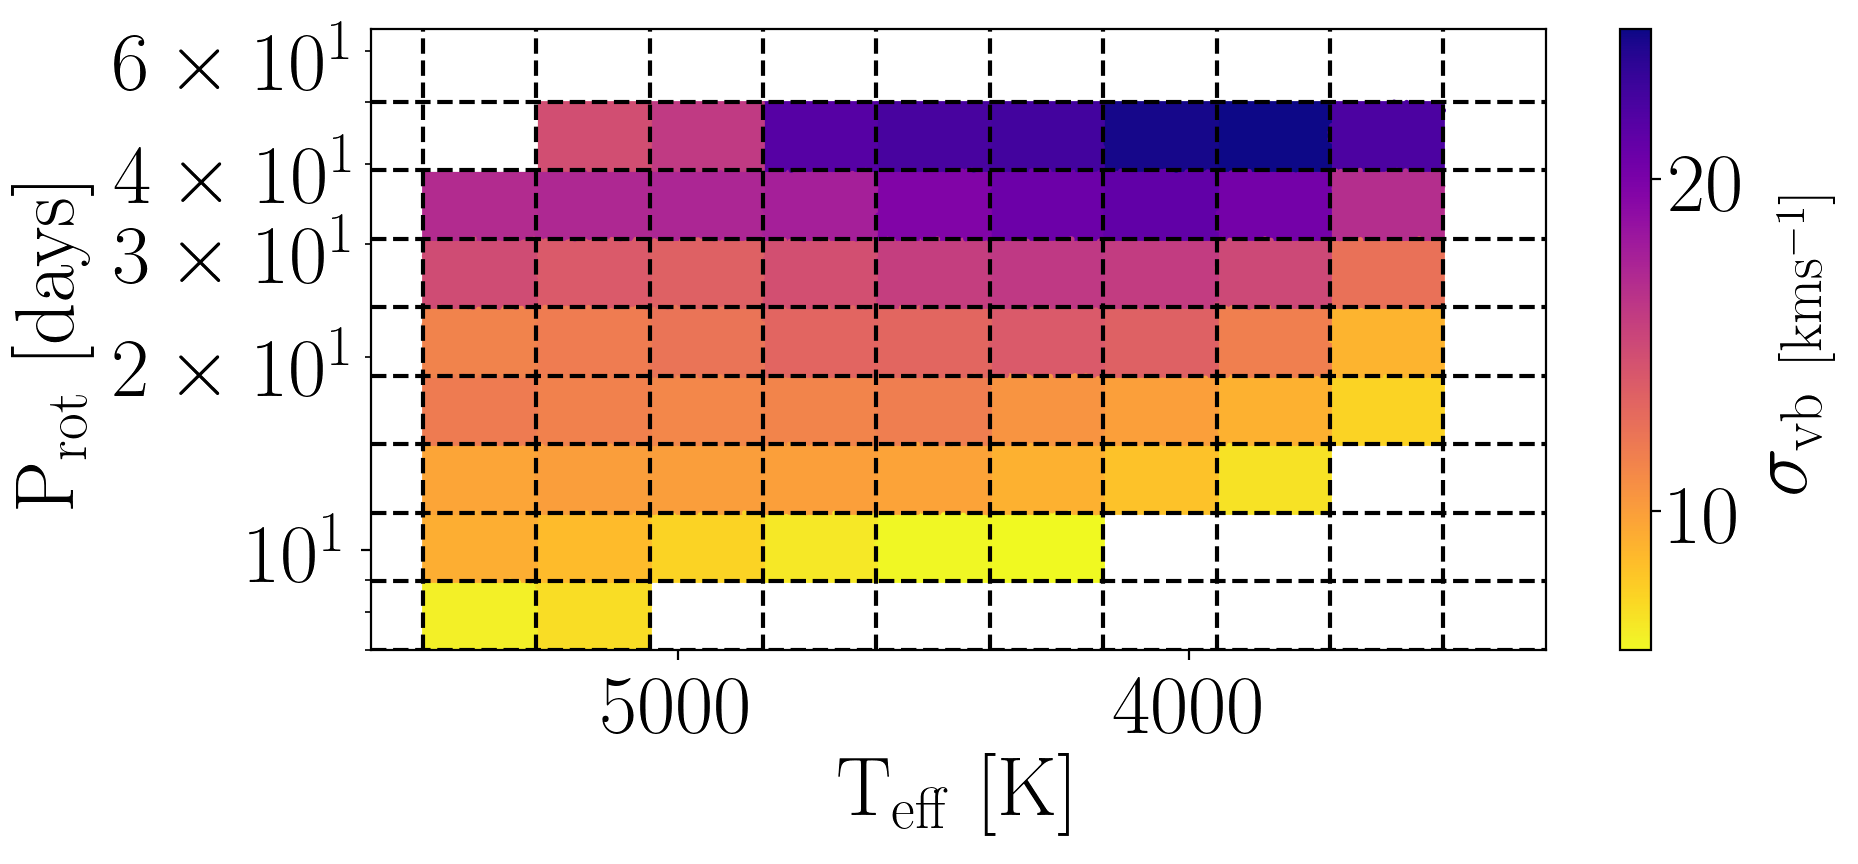

In [84]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".1", alpha=.1, ms=2,
#          mec="none", rasterized=True, zorder=1)
# plt.plot(gaia_mc.color_teffs, gaia_mc.Prot, "ko", mec="k", ms=.5, 
#          alpha=.2, rasterized=True, zorder=3)

for i, m in enumerate(period_masks):
    plt.axhline(period_bins[i], color="k", ls="--")
    
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax,
                          rasterized=True, zorder=2, s=1, cmap="plasma_r")
        
        xs = np.linspace(tbins[j], tbins[j+1], 10)
        color = prgba_plasma[i, j]
        if not np.isfinite(pds[i, j]):
            color = "w"
        plt.fill_between(xs, np.ones_like(xs)*period_bins[i], np.ones_like(xs)*period_bins[i+1],
                         color=color, zorder=1)
        
plt.axhline(period_bins[-1], color="k", ls="--")
for t in tbins:
    plt.axvline(t, color="k", ls="--")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(xlim)
plt.yscale("log")
plt.ylim(7, 65)
plt.tight_layout()
# plt.savefig("paper/dispersion_period_teff.pdf")